# Hyperparameter Optimization

This notebook builds based on `1_basic_tutorial.ipynb` by calling optimization routines to find optimal parameters for each method.

### Notations:
  * dt: (float) step size (note: the symbol "dt" comes from differentiating timeseries data, however these functions work for a 1-dimensional spatial derivative as well)
  * x: (np.array with length N) the data you want to differentiate
  * x_hat: (np.array with length N) the smoothed estimate of x
  * x_truth: (np.array with length N) the true value of x (which is known when the data is simulated, and used for plotting purposes only)
  * dxdt_hat: (np.array with length N) the estimate of the derivative of x
  * dxdt_truth: (np.array with length N) the true value of dxdt (which is known when the data is simulated, and used for plotting purposes only)

In [1]:
import numpy as np
from matplotlib import pyplot
from pynumdiff.optimize import optimize
from pynumdiff.utils import evaluate
from pynumdiff.utils.simulate import sine, triangle, pop_dyn, linear_autonomous,\
	pi_cruise_control, lorenz_x
from pynumdiff.finite_difference import finitediff
from pynumdiff.smooth_finite_difference import kerneldiff, butterdiff
from pynumdiff.polynomial_fit import splinediff, polydiff, savgoldiff
from pynumdiff.basis_fit import spectraldiff, rbfdiff
from pynumdiff.total_variation_regularization import tvrdiff, smooth_acceleration
from pynumdiff.kalman_smooth import rtsdiff, robustdiff
from pynumdiff.linear_model import lineardiff

## Optimizing with and without ground truth

There are two main scenarios:
1. The true derivative is known, so we can target it directly
2. Actual dxdt is unknown, so we have to target a proxy

In the real world, option (1) is not possible, so for (2) we use a loss function that balances the faithfulness and smoothness of the derivative estimate, balanced by a single hyperparameter, $\gamma$, or `tvgamma` in the code:

$$L = \sigma \sqrt{\frac{2}{N}\sum\text{Huber}\bigg( \frac{\mathbf{\hat{x}}(\Phi) - \mathbf{y}}{\sigma}, M \bigg)} + \gamma \bigg({TV}\big(\mathbf{\hat{\dot{x}}}(\Phi)\big)\bigg),$$
where the left term is a generalization of RMSE that uses the Huber loss, $\sigma$ is a robust scatter measure, $M$ is a robustness parameter in units of $\sigma$ (often set to 2 or 3 so the vast majority of inliers are measured with RMSE), $\mathbf{\hat{x}}$ is the estimate of the true underlying signal, $\mathbf{y}$ are the noisy measurements, $\mathbf{\hat{\dot{x}}}$ is the estimate of the derivative, $\gamma$ is a hyper-parameter, and $TV$ is the total variation,

$$TV(\mathbf{\hat{\dot{x}}}) = \frac{1}{m}\left\lVert\mathbf{\hat{\dot{x}}}_{0:m-1}-\mathbf{\hat{\dot{x}}}_{1:m}\right\rVert_{1}.$$

See the paper for more detail. If $\gamma$ is unknown, it can be found according to the following heuristic:

In [2]:
noise_type = 'normal' # noise is generated using np.random, e.g. 'normal', 'uniform', 'poisson'
noise_parameters = [0, 0.1]  # compatible with np.random functions 
dt = 0.01 # step size and series length in terms of independent variable
duration = 4
problem = pi_cruise_control # select one of the options imported from the simulate module
cutoff_frequency = 2.5 # high frequency of signal in the data. 

# estimate by (a) counting real # peaks per second in the data or (b) look at power spectrum and choose cutoff. 
log_gamma = -1.6*np.log(cutoff_frequency) -0.71*np.log(dt) - 5.1
tvgamma = np.exp(log_gamma)
print("tvgamma:", tvgamma)

tvgamma: 0.03701639564505169


Optimization follows this pattern:

```python
from pynumdiff.optimize import optimize
from pynumdiff.module import method

search_space_updates = {'param1':[values], 'param2':[values], ...}

params, val = optimize(method, x, dt,
                    tvgamma=tvgamma, # hyperparameter
                    dxdt_truth=dxdt_truth, # defaults to None if no ground truth data
                    search_space_updates=search_space_updates)
					
x_hat, dxdt_hat = method(x, dt, **params)
```

where `param`s are keyword arguments that come from the method definition. If you don't know a search space, default search spaces are defined for all methods in `optimize.py`. Partial search spaces are accepted, simply replacing relevant entries in the default search space. Reasonable upper and lower bounds are defined for numerical search space dimensions (type `int` or `float`). Categorical dimensions can also be searched over by providing values in sets rather than lists.

Only either `tvgamma` or `dxdt_truth` is needed, to target either the true derivative or the proxy loss.

# 0. Simulate some data

pynumdiff comes with 6 different toy problems (choose the one that most resembles your data to see how the methods compare):
* lorenz_x: (nonlinear) x component of a lorenz attractor
* sine: (linear) sum of two sines
* pop_dyn: (nonlinear) bounded exponential growth
* triangle: (nonlinear) sharp-edged triangle wave with increasing frequency
* pi_cruise_control: (linear / nonlinear) linear proportional integral controller with nonlinear control inputs

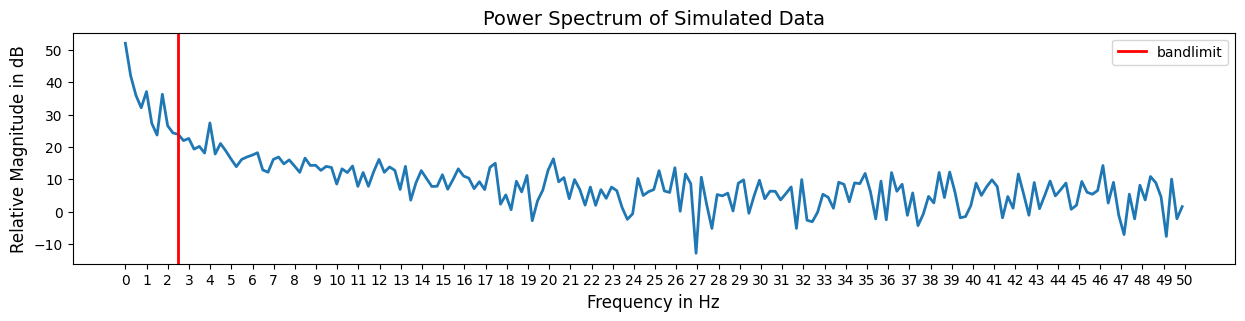

In [3]:
x, x_truth, dxdt_truth = problem(duration, noise_type=noise_type, outliers=False,
                                noise_parameters=noise_parameters, dt=dt)

X = np.fft.fft(x)
energy = 20*np.log10(np.abs(X))
freqs = np.fft.fftfreq(len(X), dt)
energy = energy[freqs >=0]
freqs = freqs[freqs >= 0]

pyplot.figure(figsize=(15,3))
pyplot.plot(freqs, energy, linewidth=2)
pyplot.axvline(x=cutoff_frequency, color='red', linewidth=2, label="bandlimit")
pyplot.xticks(np.arange(51))
pyplot.title("Power Spectrum of Simulated Data", fontsize=14)
pyplot.xlabel("Frequency in Hz", fontsize=12)
pyplot.ylabel("Relative Magnitude in dB", fontsize=12)
pyplot.legend();

## 1. Smooth Finite Difference

### 1.1 Kernel smoothing

Optimal parameters: {'window_size': 20, 'num_iterations': 1, 'kernel': 'gaussian'}
val = 0.6456841747296548 is the minimal 'rmse' by default but can also minimize 'error_correlation'
Optimal parameters: {'window_size': 3, 'num_iterations': 12, 'kernel': 'mean'} loss: 0.10533581742461928


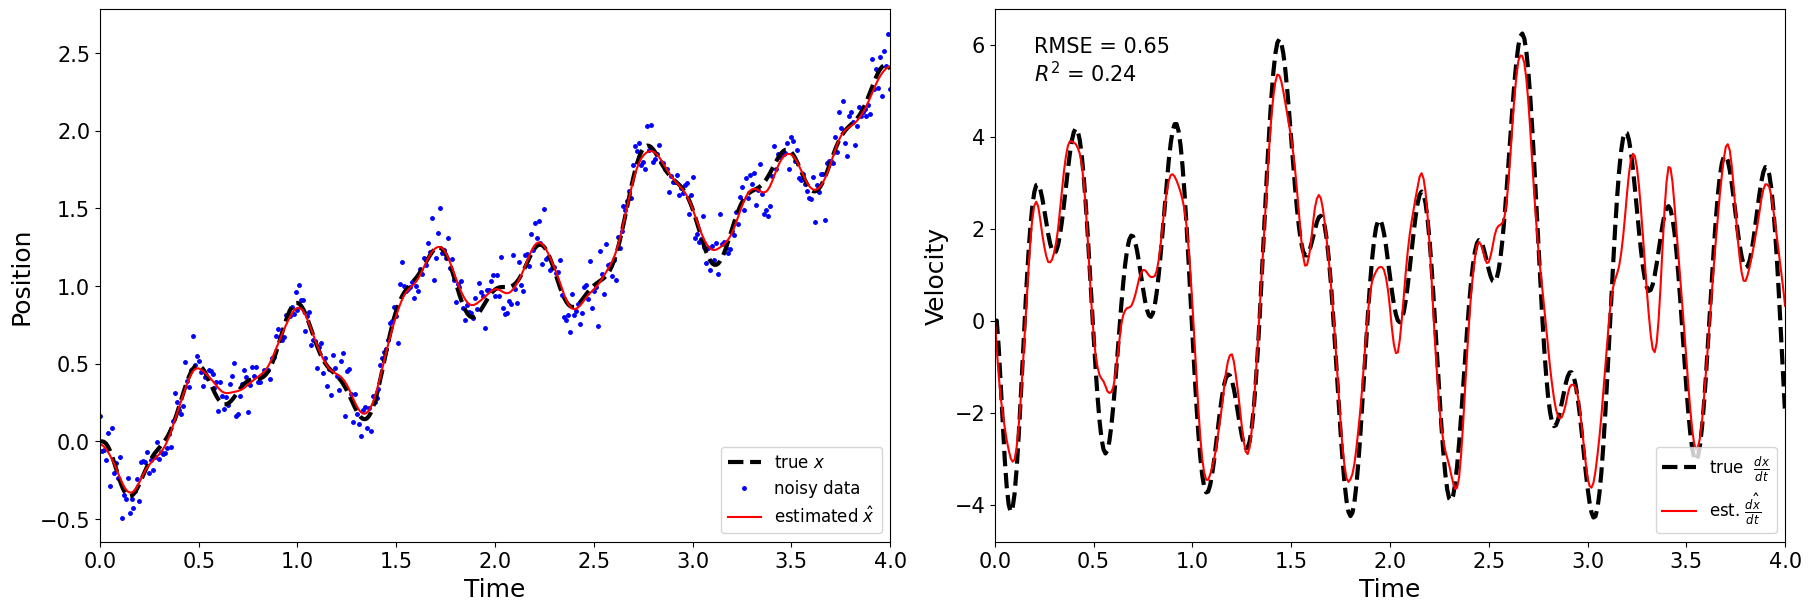

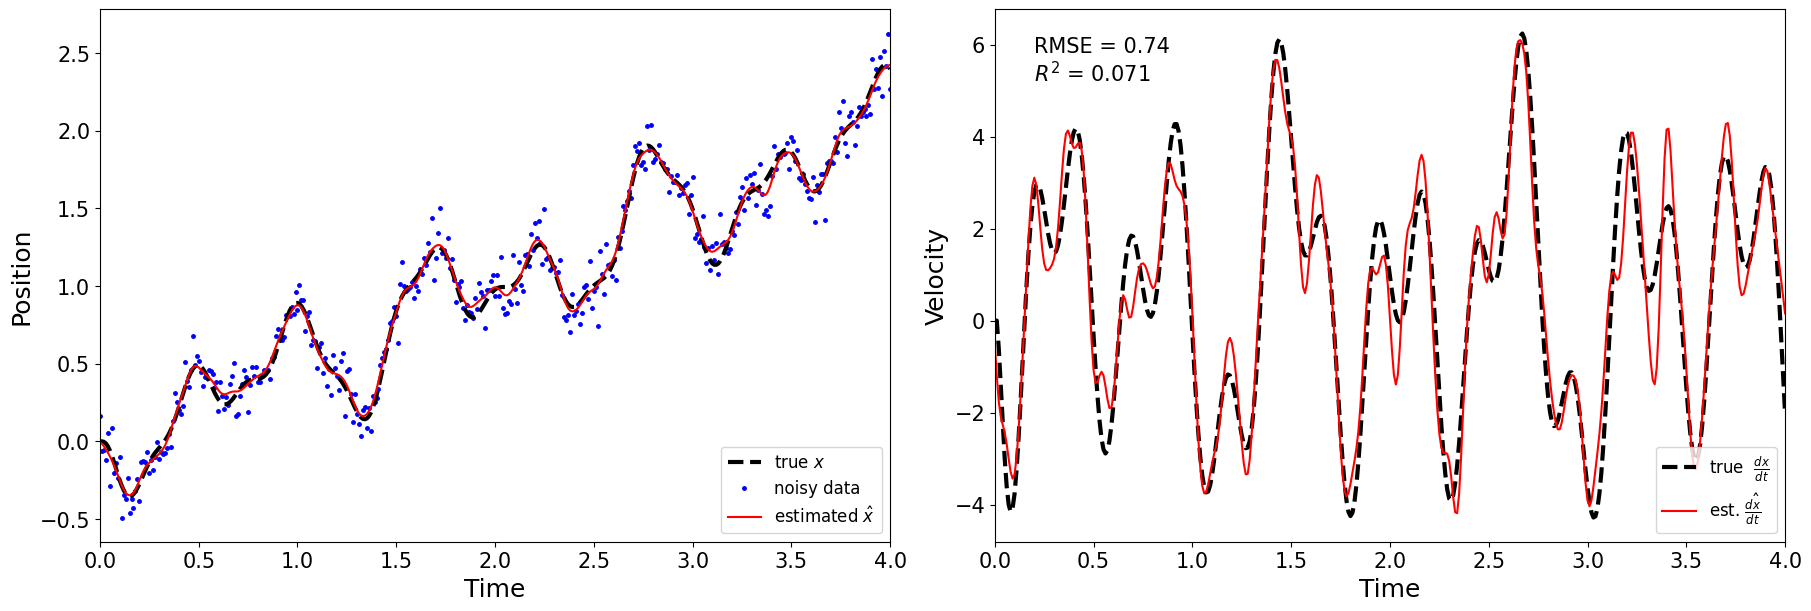

In [4]:
params, val = optimize(kerneldiff, x, dt, dxdt_truth=dxdt_truth, metric='rmse')
print('Optimal parameters:', params)
print(f"val = {val} is the minimal 'rmse' by default but can also minimize 'error_correlation'")
x_hat, dxdt_hat = kerneldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

params, val = optimize(kerneldiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters:', params, 'loss:', val)
x_hat, dxdt_hat = kerneldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 1.2 Butterworth smoothing

Optimal parameters: {'cutoff_freq': np.float64(0.09484375), 'num_iterations': 1, 'filter_order': 4}
Optimal parameters: {'cutoff_freq': np.float64(0.10968750000000001), 'num_iterations': 1, 'filter_order': 2} loss: 0.10596492282119169


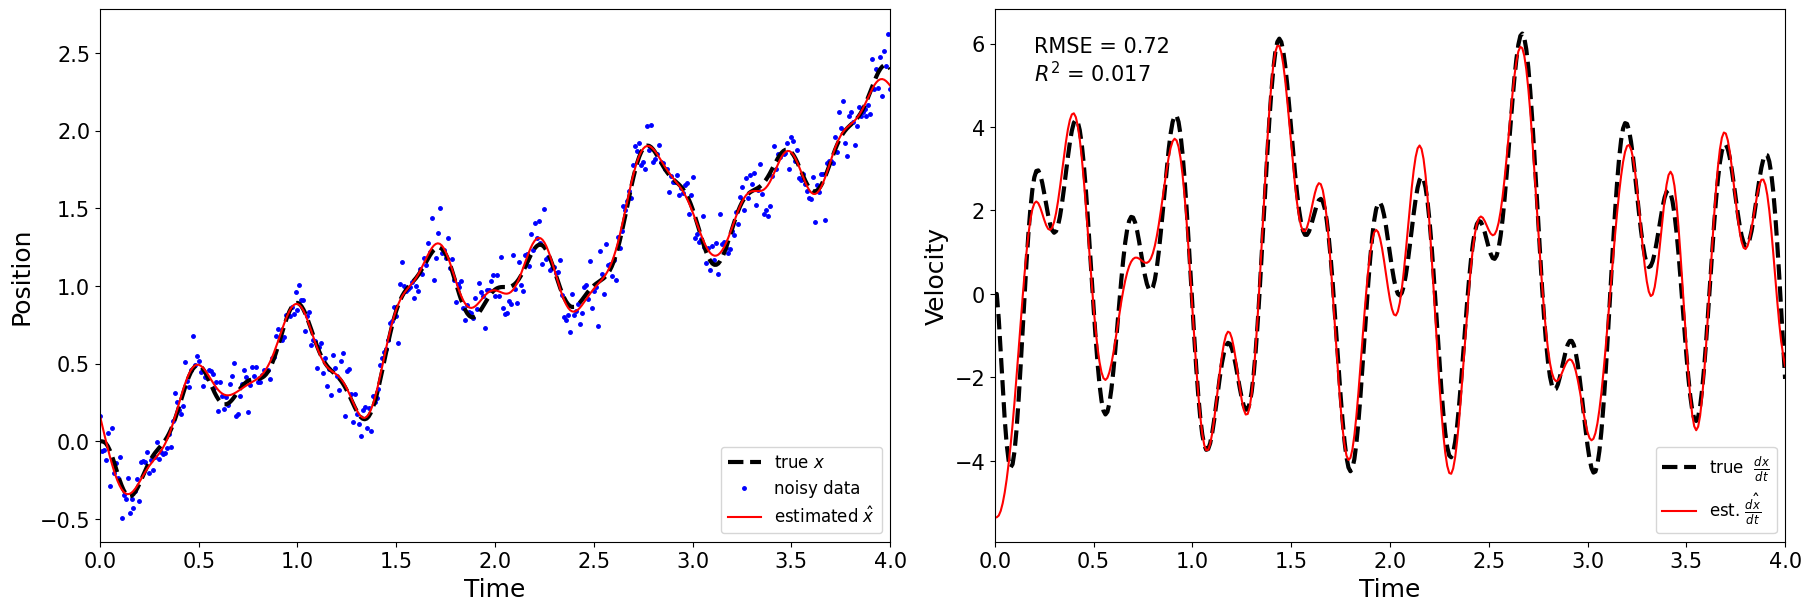

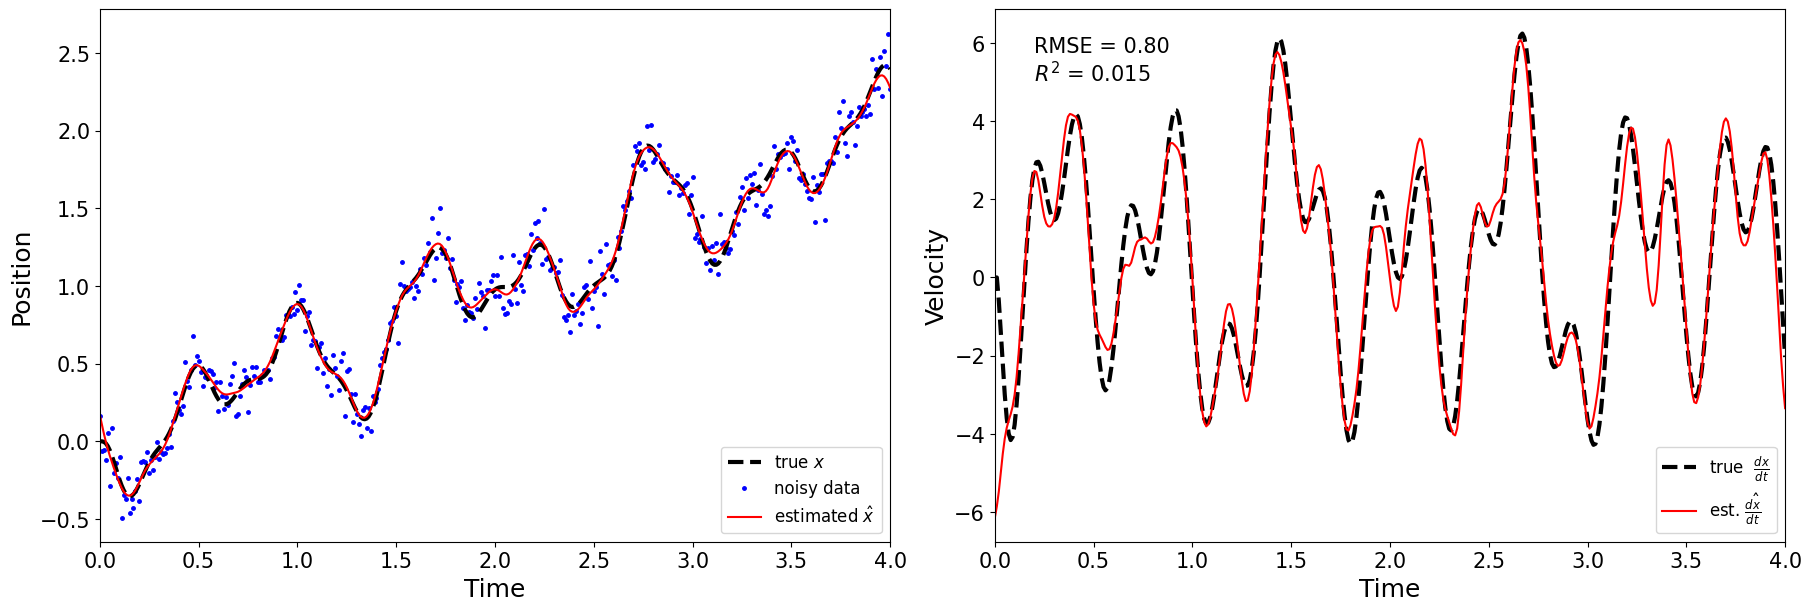

In [5]:
params, val = optimize(butterdiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters:', params)
x_hat, dxdt_hat = butterdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

params, val = optimize(butterdiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters:', params, 'loss:', val)
x_hat, dxdt_hat = butterdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

## 2. Iterated Finite Difference

Optimal parameters: {'num_iterations': 73, 'order': 4}
Optimal parameters: {'num_iterations': 50, 'order': 4} loss: 0.10512829446365361


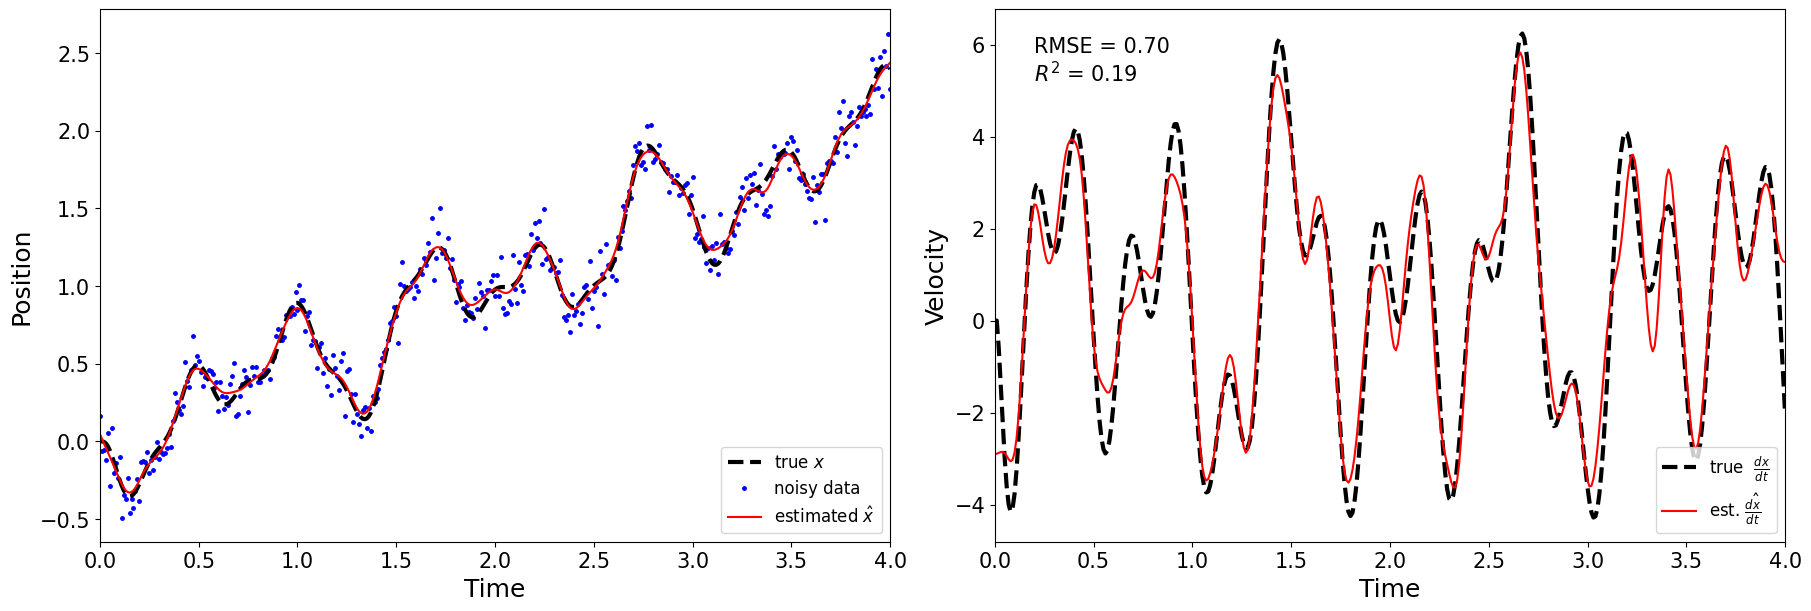

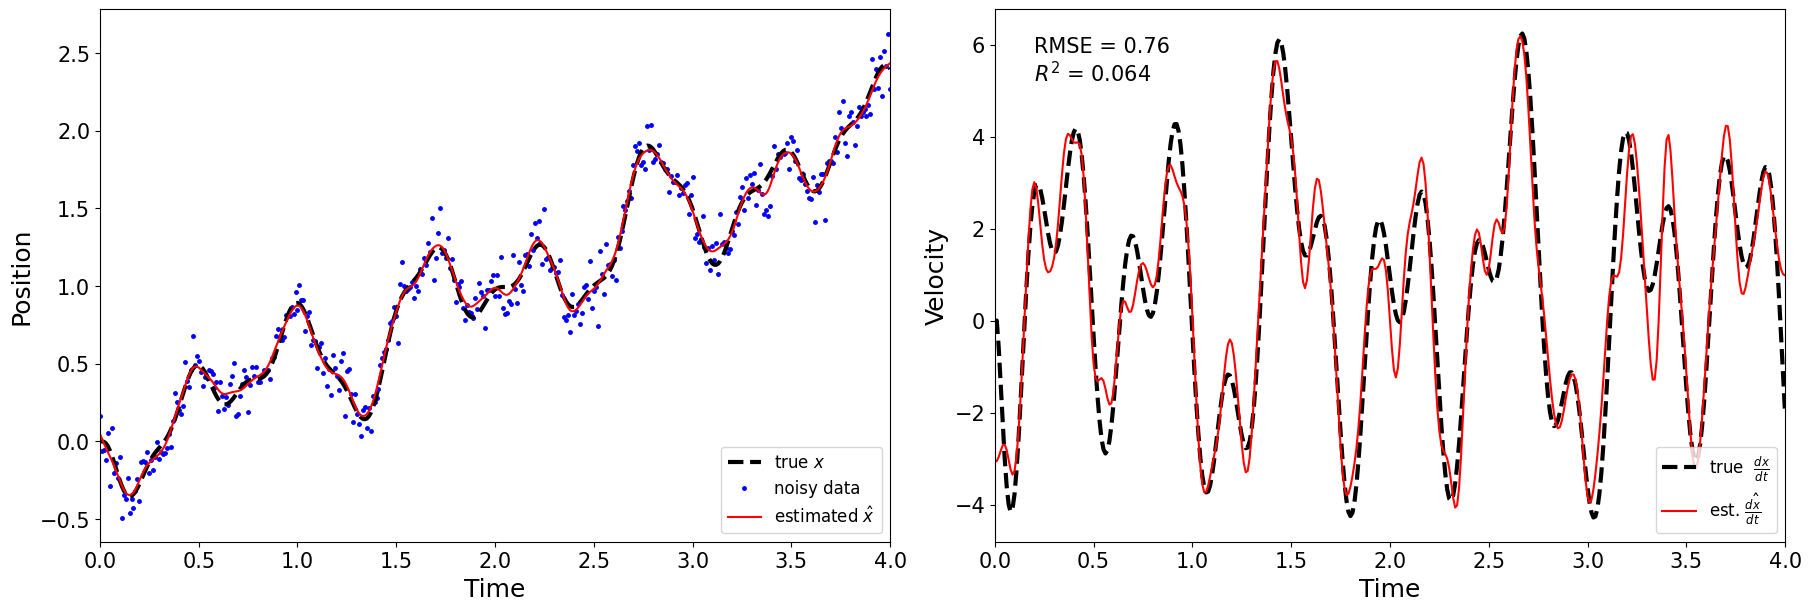

In [6]:
params, val = optimize(finitediff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters:', params)
x_hat, dxdt_hat = finitediff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

params, val = optimize(finitediff, x, dt, tvgamma=tvgamma)
print('Optimal parameters:', params, 'loss:', val)
x_hat, dxdt_hat = finitediff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

## 3. Polynomial-Based Methods

### 3.1 Sliding polynomial fit

Optimal parameters: {'step_size': 1, 'degree': 3, 'window_size': 40, 'kernel': 'friedrichs'}
Optimal parameters: {'step_size': 1, 'degree': 2, 'window_size': 37, 'kernel': 'gaussian'} loss: 0.10160078422541934


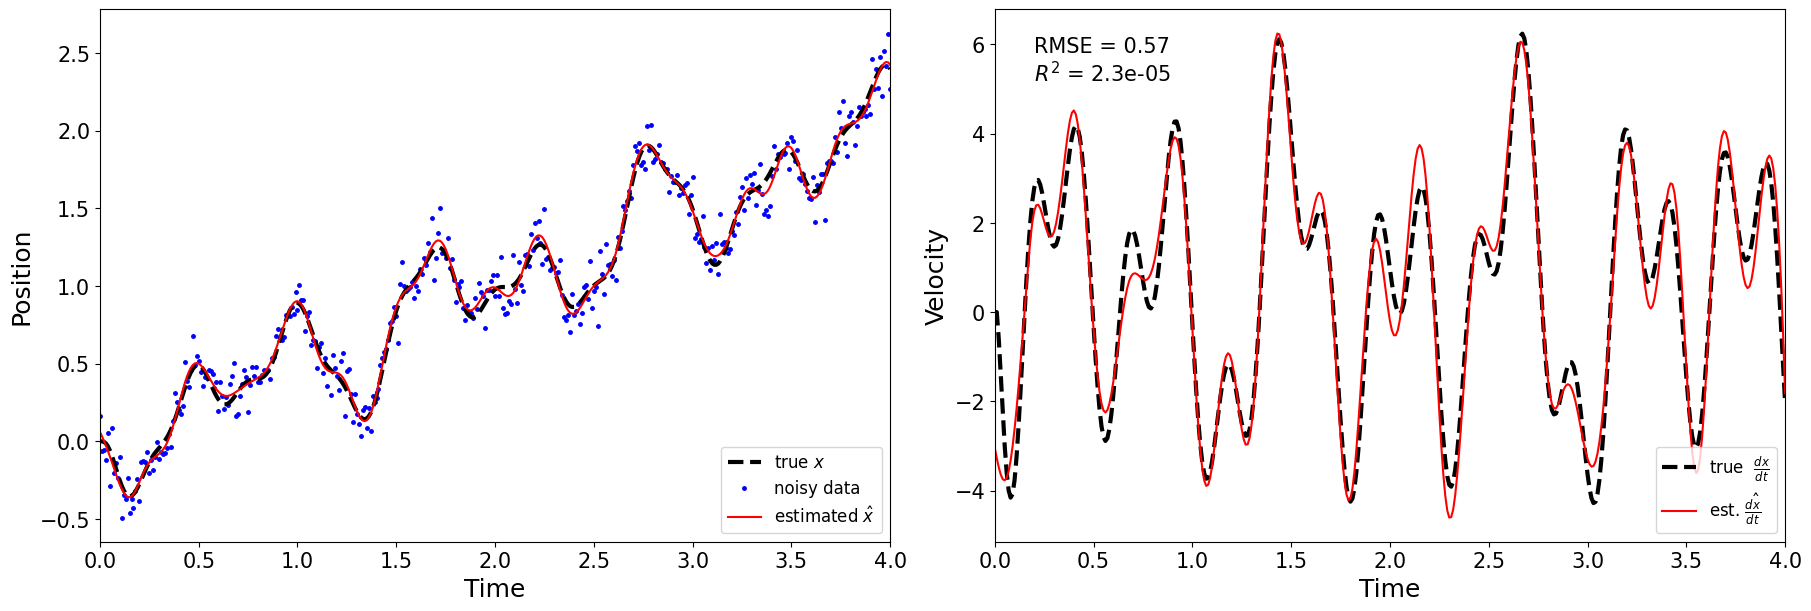

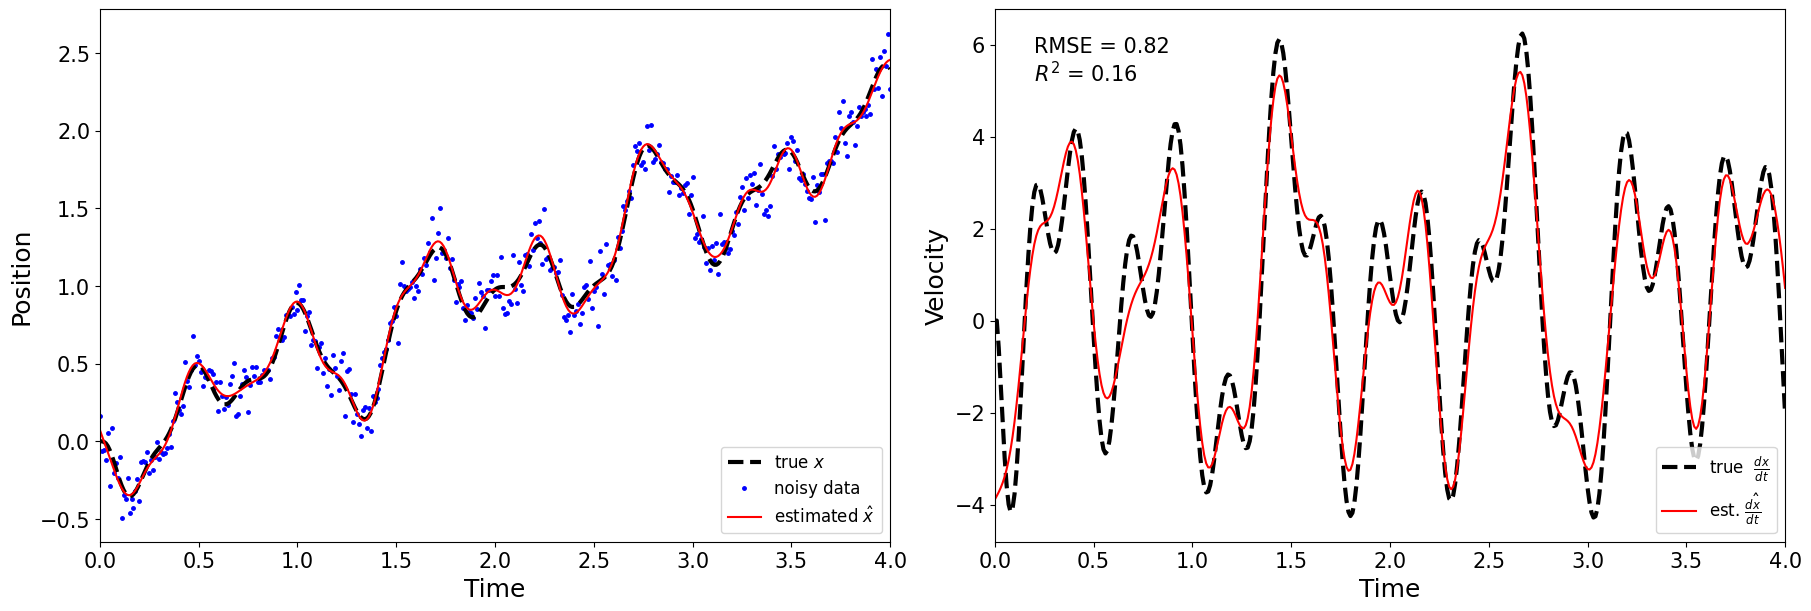

In [7]:
params, val = optimize(polydiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters:', params)
x_hat, dxdt_hat = polydiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

params, val = optimize(polydiff, x, dt, tvgamma=tvgamma, search_space_updates={'step_size':[1, 2, 5]})
print('Optimal parameters:', params, 'loss:', val)
x_hat, dxdt_hat = polydiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 3.2 Savitzky-Golay filter

Optimal parameters: {'degree': 5, 'window_size': 39, 'smoothing_win': 12}
Optimal parameters: {'degree': 3, 'window_size': 12, 'smoothing_win': 17} loss: 0.10577857769263474


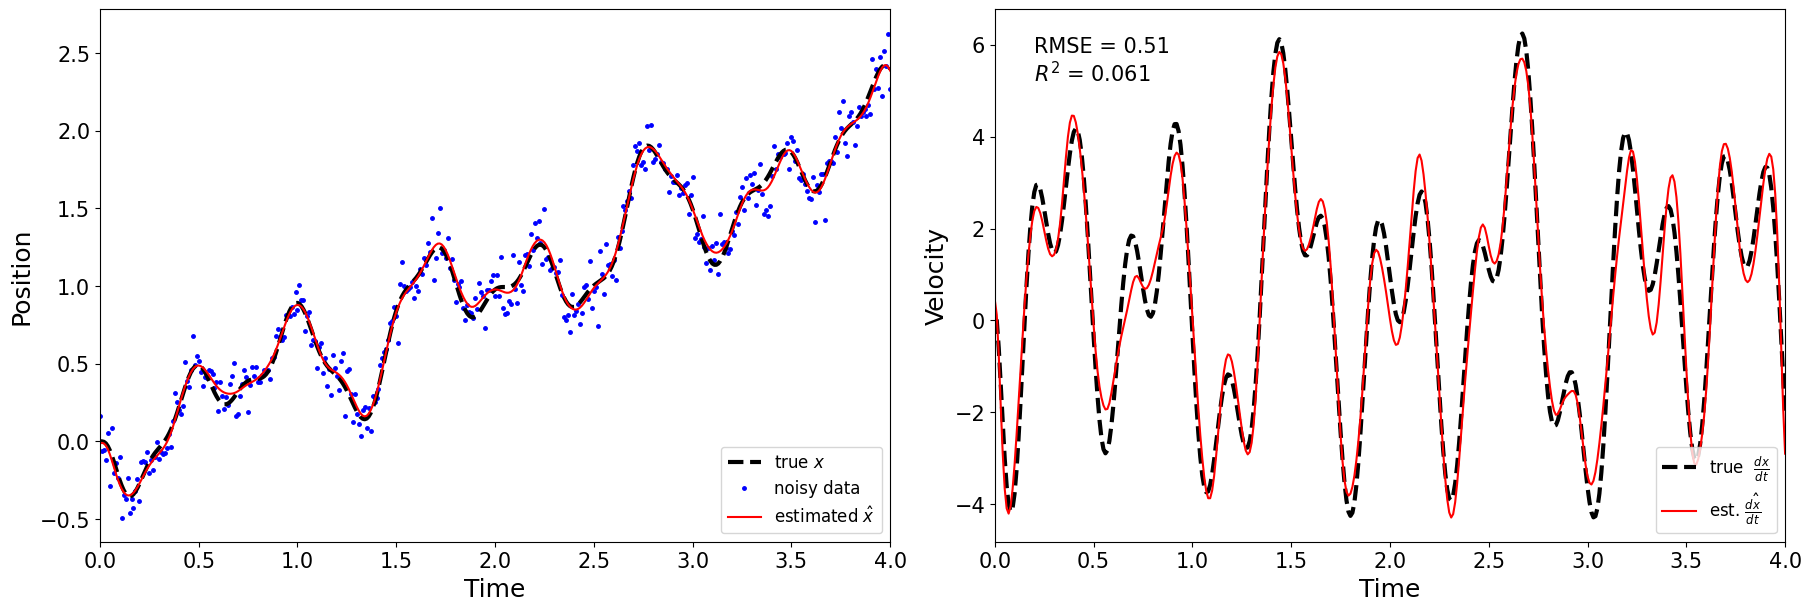

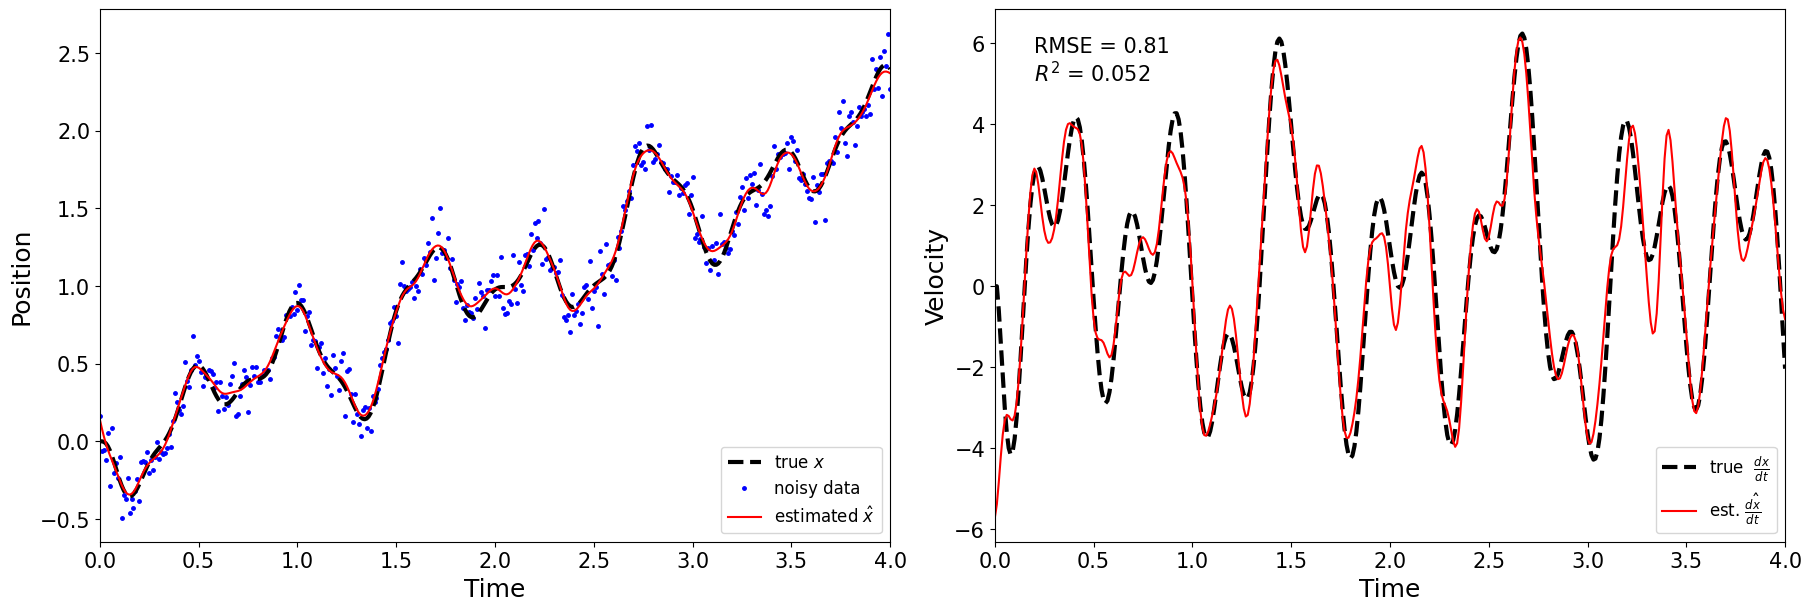

In [8]:
params, val = optimize(savgoldiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters:', params)
x_hat, dxdt_hat = savgoldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

params, val = optimize(savgoldiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters:', params, 'loss:', val)
x_hat, dxdt_hat = savgoldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 3.3 Splines

Optimal parameters: {'s': np.float64(0.5531249999999999), 'num_iterations': 5, 'degree': 3}
Optimal parameters: {'s': np.float64(0.5531249999999998), 'num_iterations': 5, 'degree': 3} loss: 0.10760609791061375


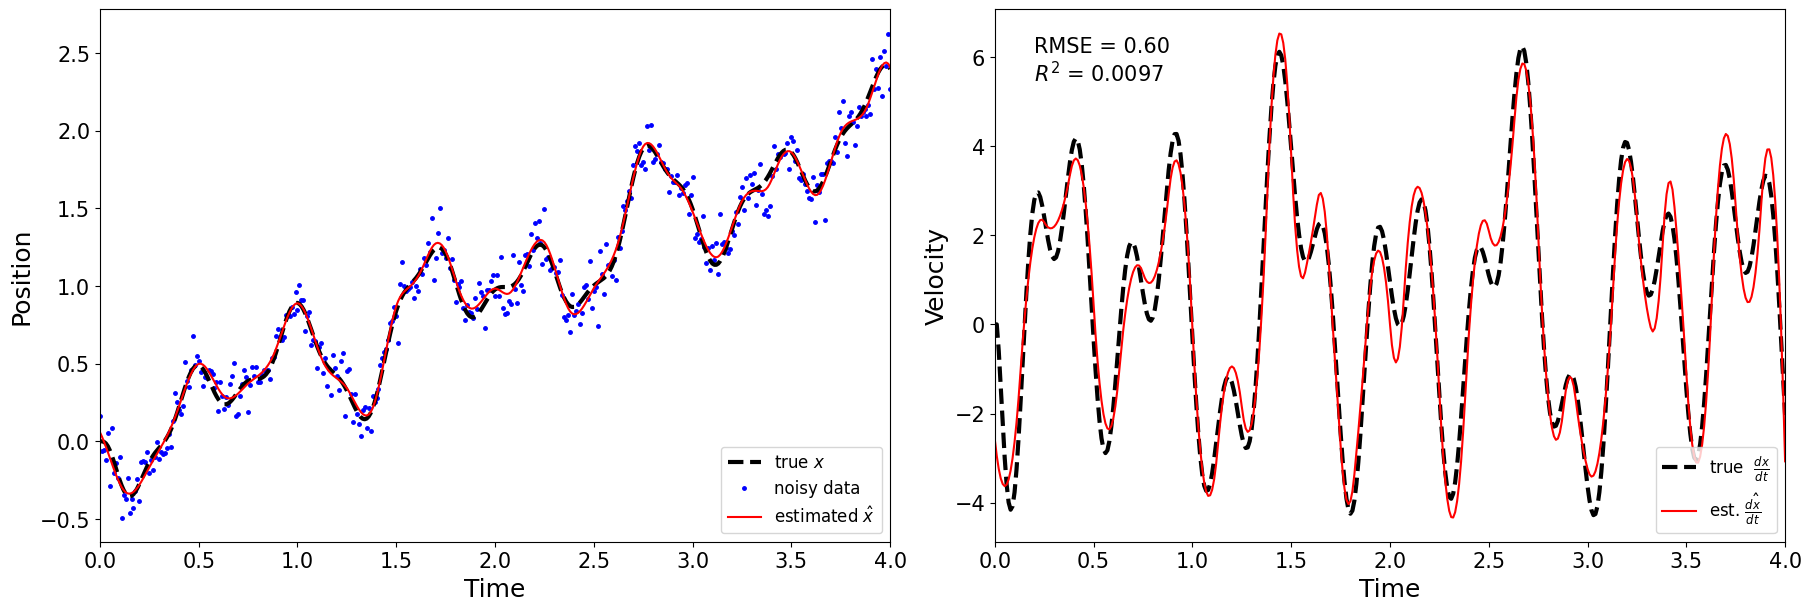

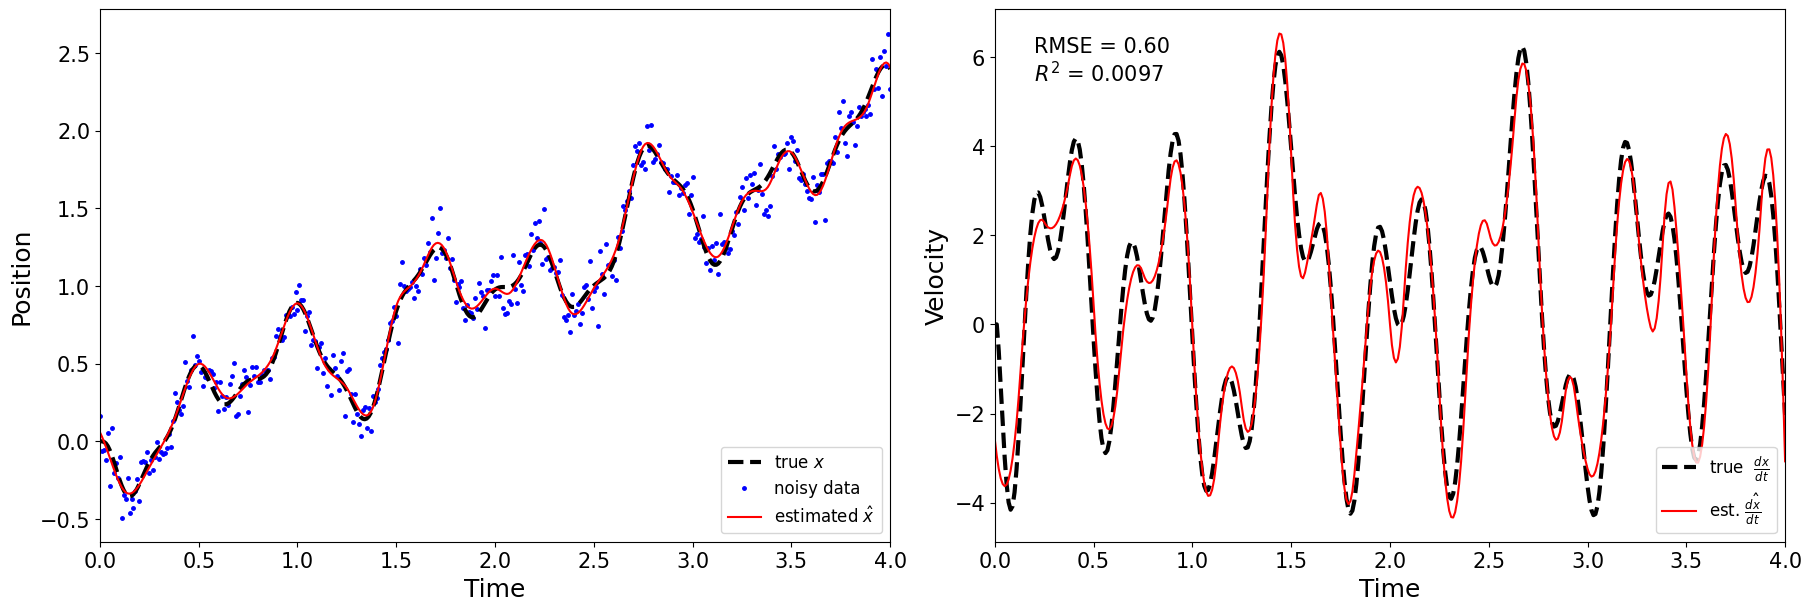

In [9]:
params, val = optimize(splinediff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters:', params)
x_hat, dxdt_hat = splinediff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

params, val = optimize(splinediff, x, dt, tvgamma=tvgamma)
print('Optimal parameters:', params, 'loss:', val)
x_hat, dxdt_hat = splinediff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

## 4. Basis-Function-Based Methods

### 4.1 Spectral Derivative with Tricks

Optimal parameters: {'high_freq_cutoff': np.float64(0.08906250000000004), 'pad_to_zero_dxdt': True, 'even_extension': True}
Optimal parameters: {'high_freq_cutoff': np.float64(0.11750000000000005), 'pad_to_zero_dxdt': False, 'even_extension': True} loss: 0.10744310739434879


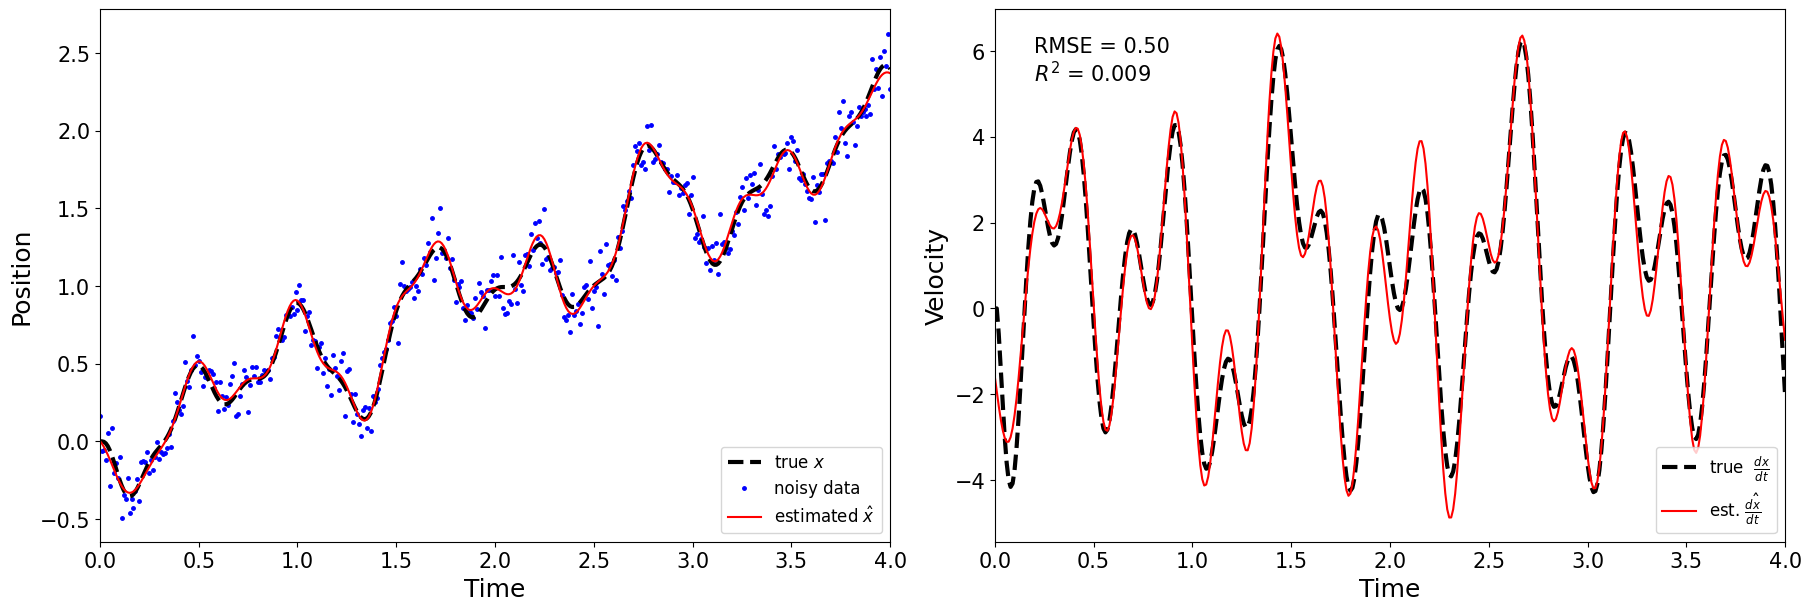

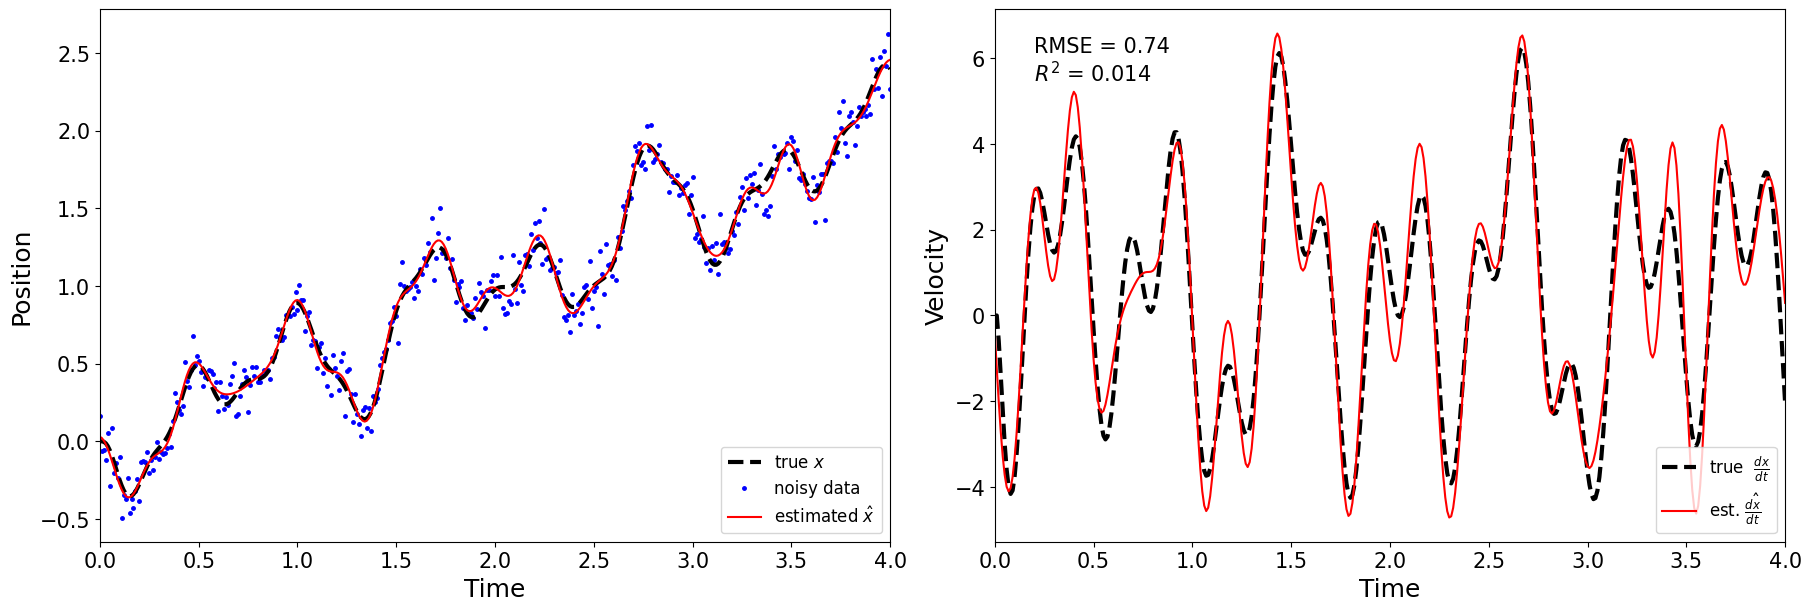

In [10]:
params, val = optimize(spectraldiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters:', params)
x_hat, dxdt_hat = spectraldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

params, val = optimize(spectraldiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters:', params, 'loss:', val)
x_hat, dxdt_hat = spectraldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 4.2 Radial Basis Functions

Fit and differentiate a local basis.

Optimal parameters: {'sigma': np.float64(0.11624999999999996), 'lmbd': np.float64(0.09499999999999995)}
Optimal parameters: {'sigma': np.float64(0.11451171875000003), 'lmbd': np.float64(0.092060546875)} loss: 0.10678436849609682


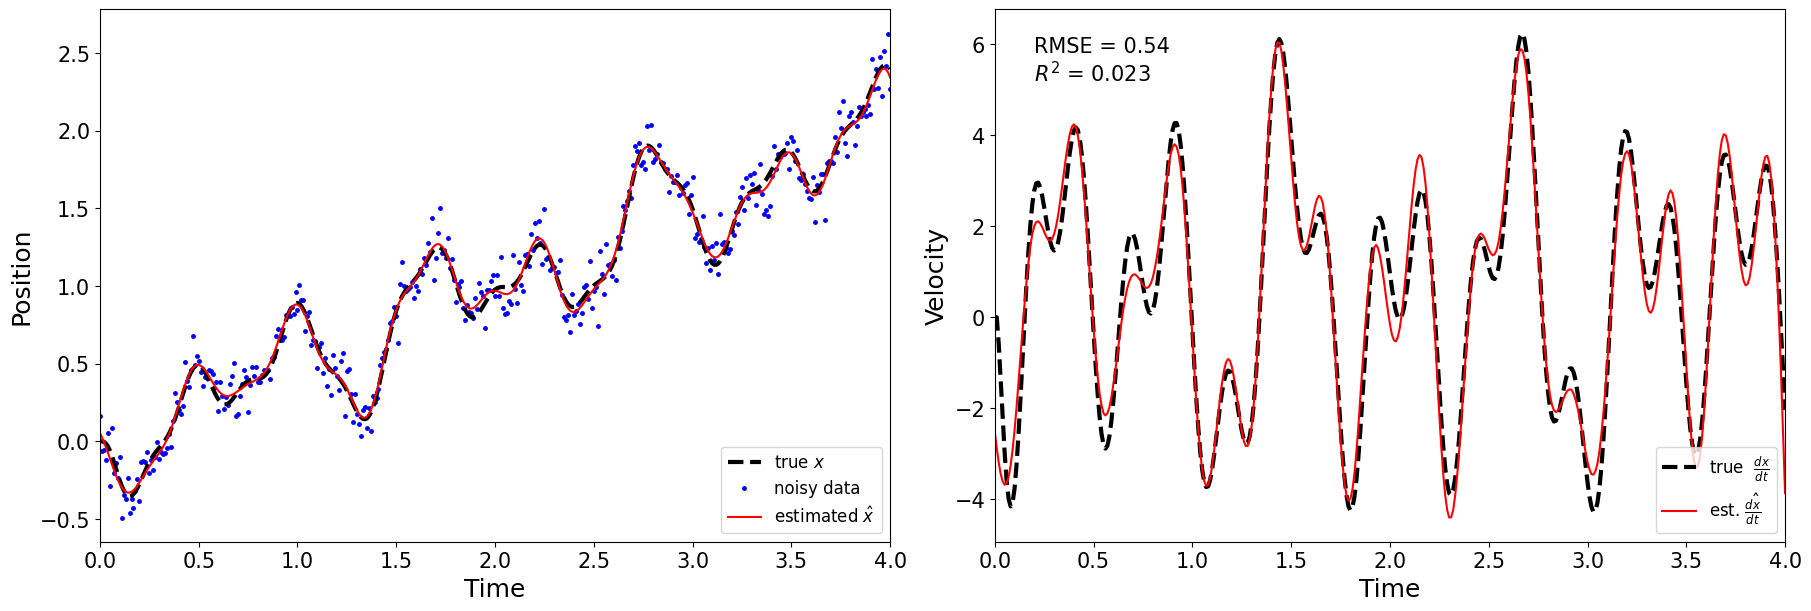

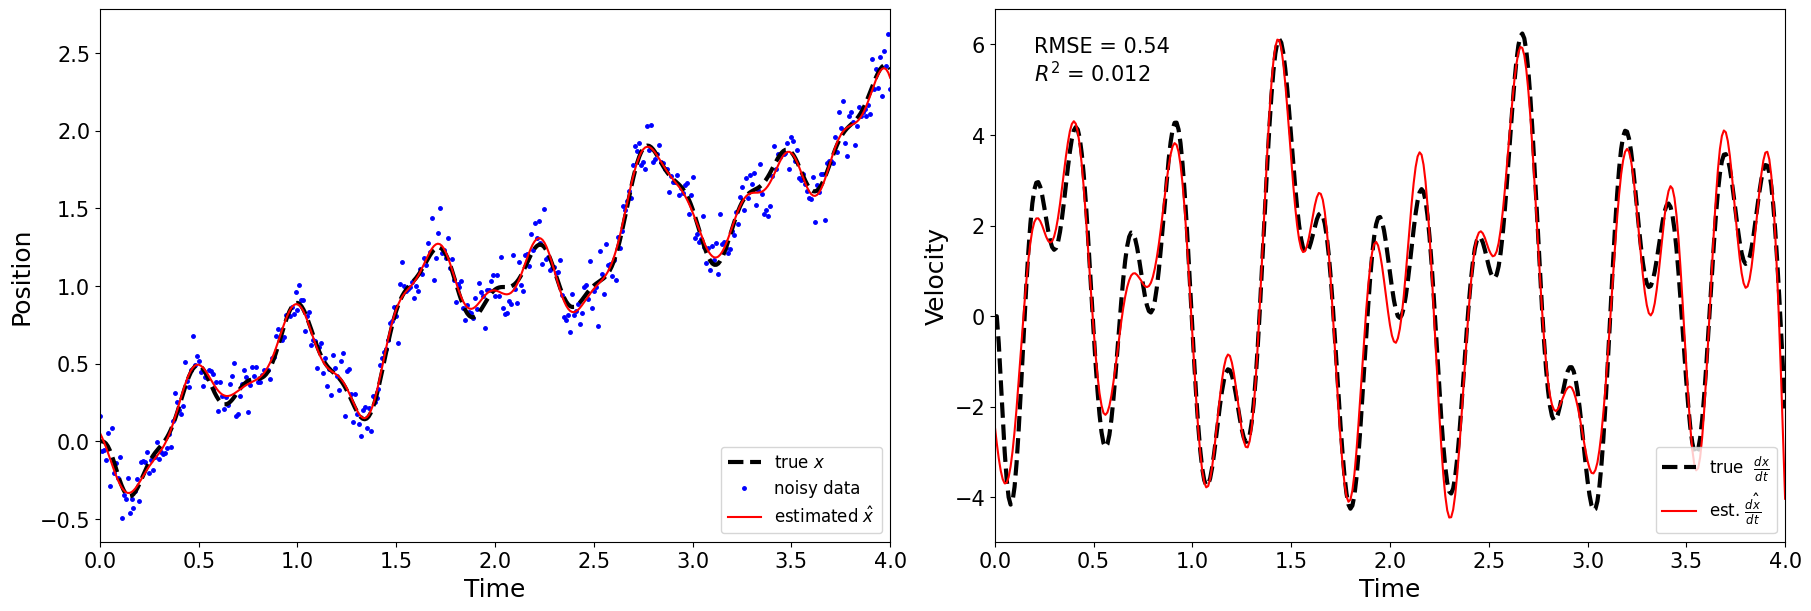

In [11]:
params, val = optimize(rbfdiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters:', params)
x_hat, dxdt_hat = rbfdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

params, val = optimize(rbfdiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters:', params, 'loss:', val)
x_hat, dxdt_hat = rbfdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

## 5. Total Variation Regularization

### 5.1 Convex TVRed Derivative

Optimal parameters: {'gamma': np.float64(12.46875), 'order': 3}
Optimal parameters: {'gamma': np.float64(11.484375), 'order': 3} loss: 0.10551946562937996


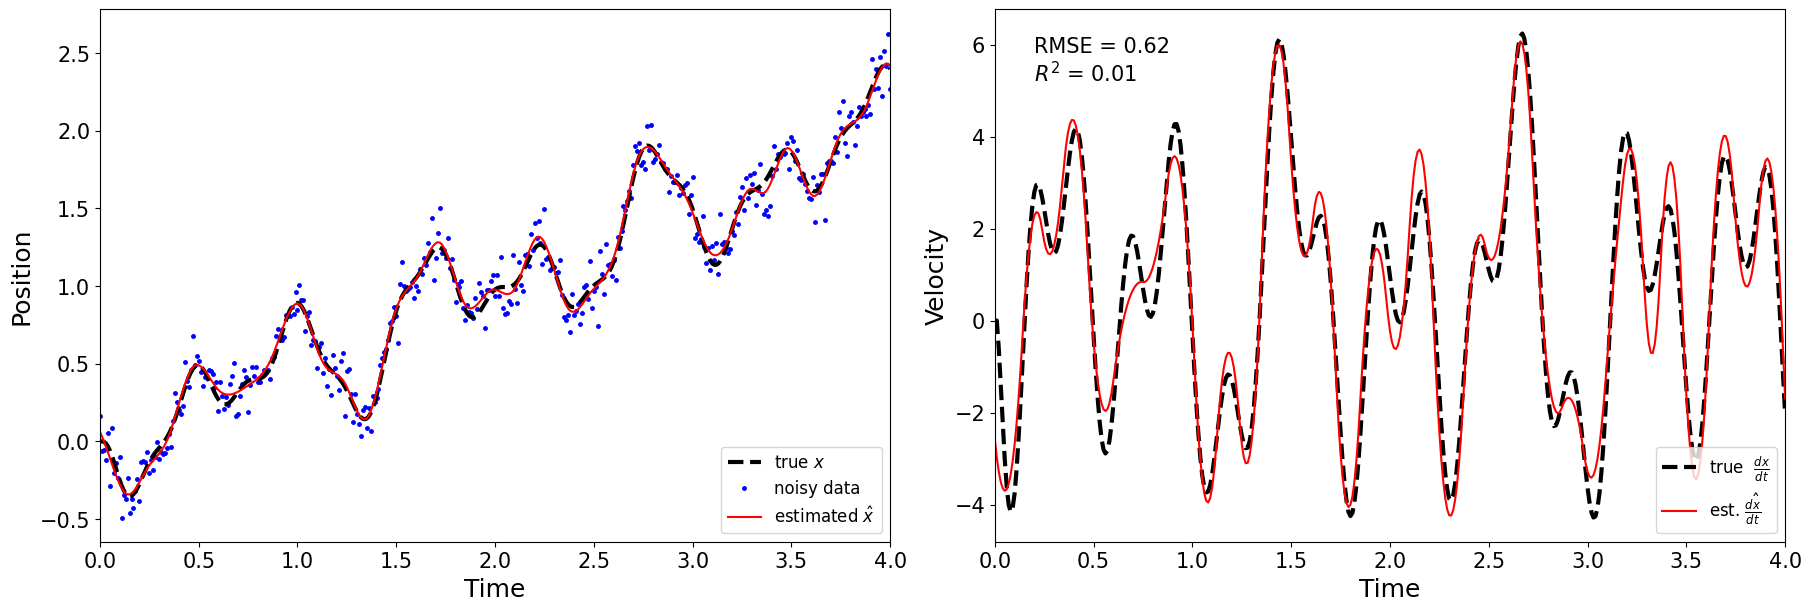

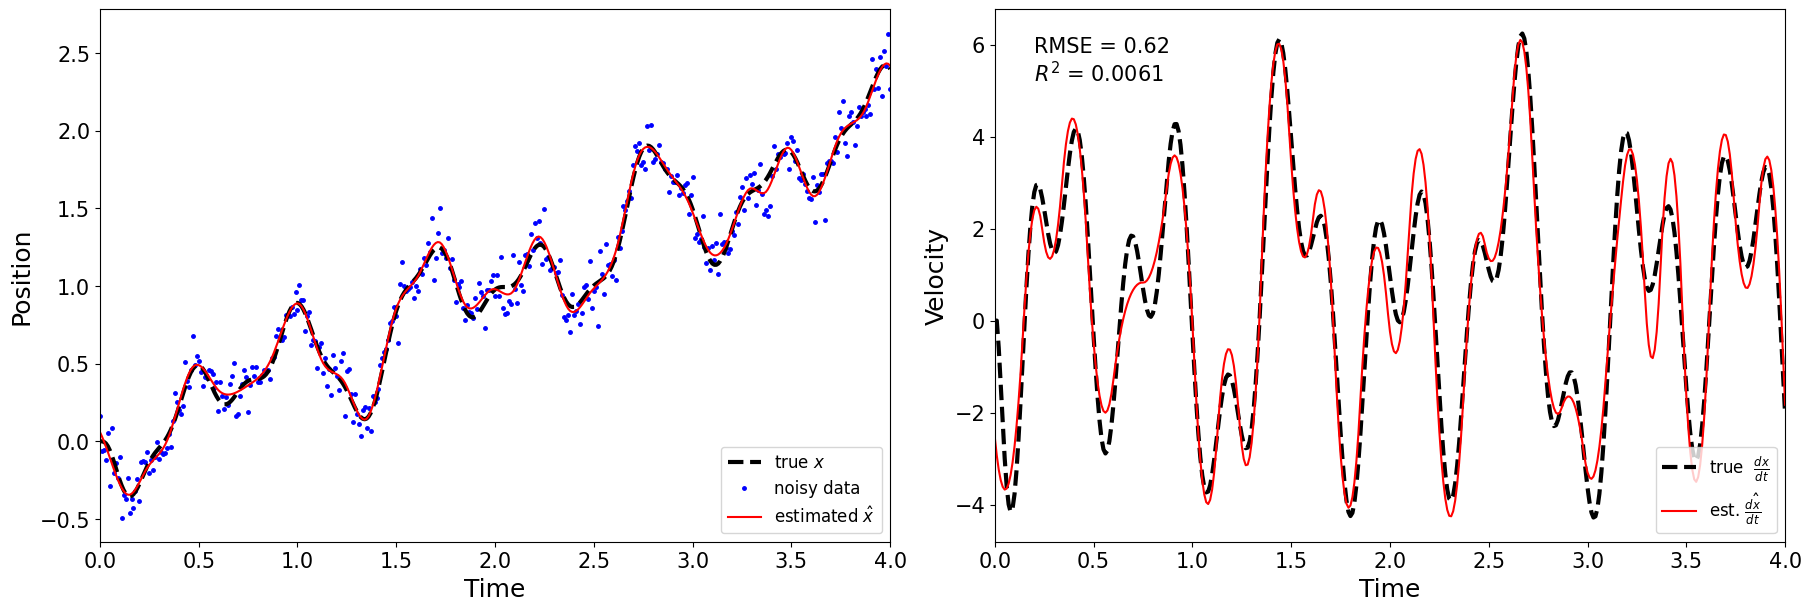

In [12]:
params, val = optimize(tvrdiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters:', params)
x_hat, dxdt_hat = tvrdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

params, val = optimize(tvrdiff, x, dt, tvgamma=tvgamma, search_space_updates={'order':{2,3}})
print('Optimal parameters:', params, 'loss:', val)
x_hat, dxdt_hat = tvrdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### 5.2 TVR acceleration with gaussian smoothing

Optimal parameters: {'gamma': np.float64(1.2152343749999992), 'window_size': 16}
Optimal parameters: {'gamma': np.float64(1.698437499999999), 'window_size': 13} loss: 0.10549771904767499


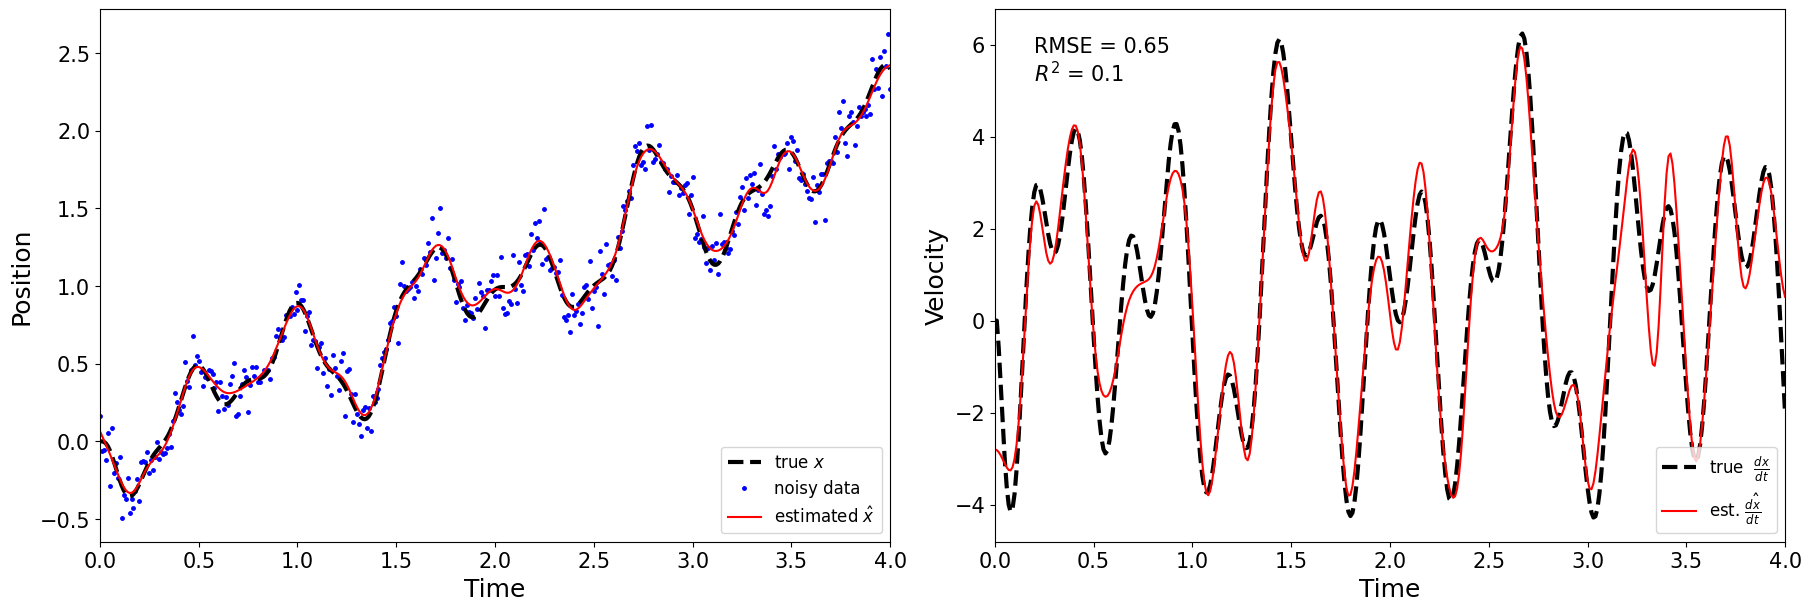

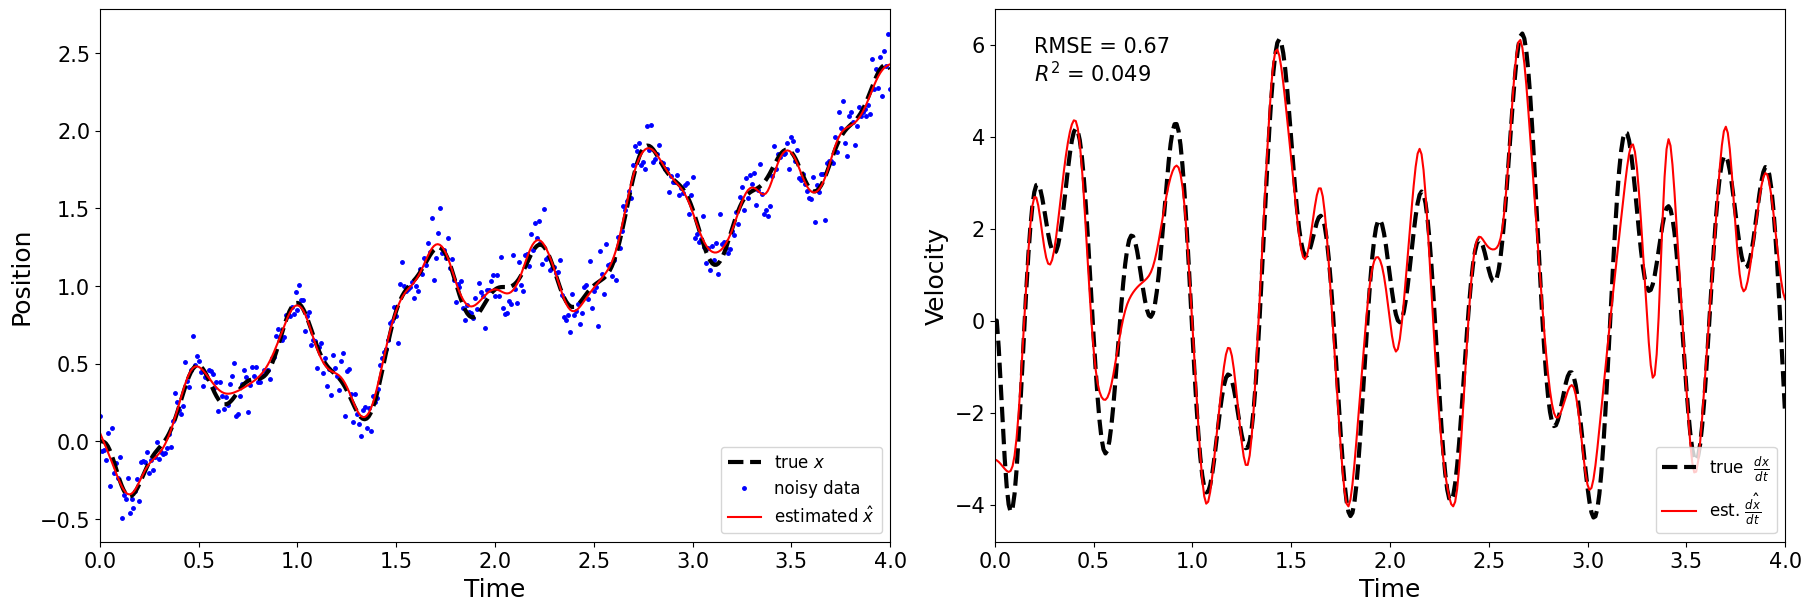

In [13]:
params, val = optimize(smooth_acceleration, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters:', params)
x_hat, dxdt_hat = smooth_acceleration(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

params, val = optimize(smooth_acceleration, x, dt, tvgamma=tvgamma)
print('Optimal parameters:', params, 'loss:', val)
x_hat, dxdt_hat = smooth_acceleration(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

## 6. Kalman smoothing

### 6.1 RTS Smoothing

Optimal parameters: {'log_qr_ratio': np.float64(9.873632812500002), 'order': 3, 'forwardbackward': True}
Optimal parameters: {'log_qr_ratio': np.float64(4.300000000000004), 'order': 1, 'forwardbackward': True} loss: 0.10423553630946636


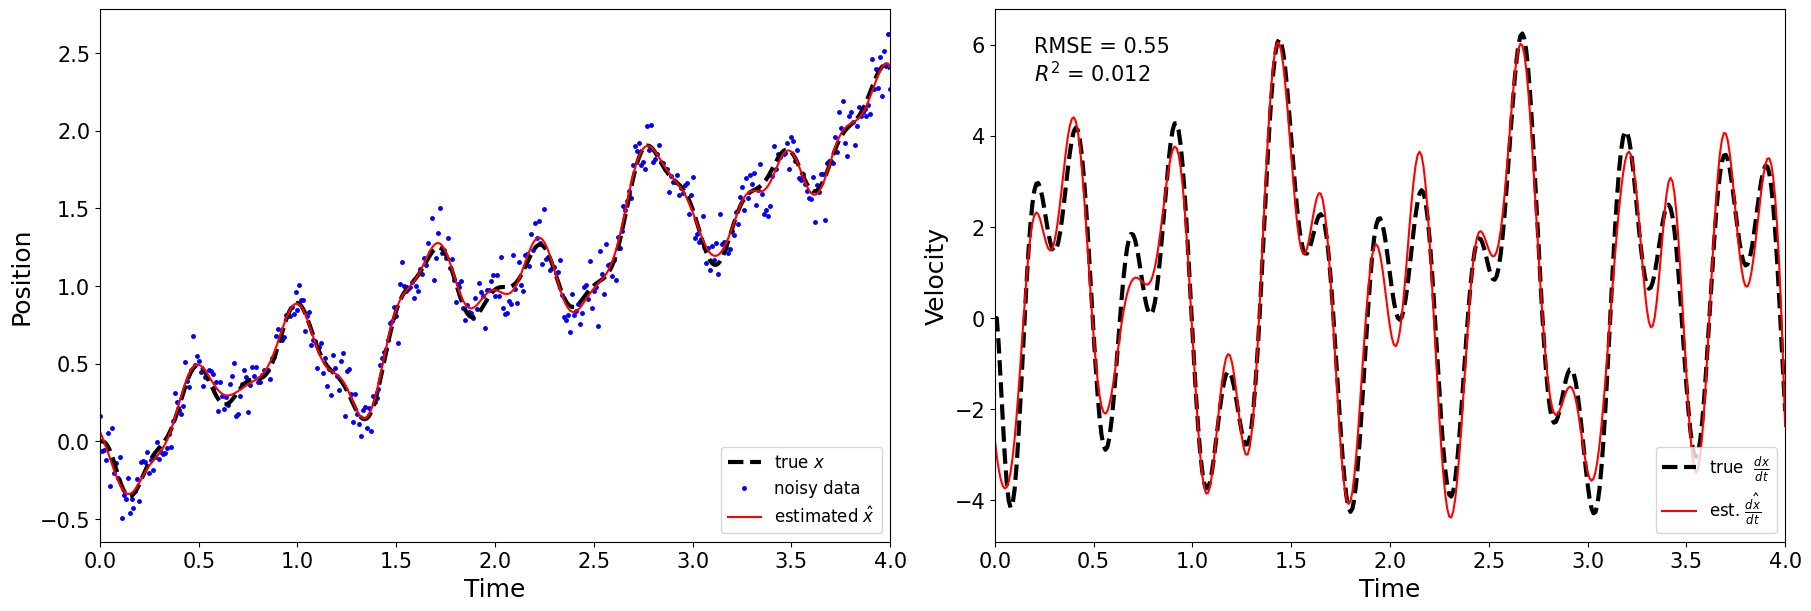

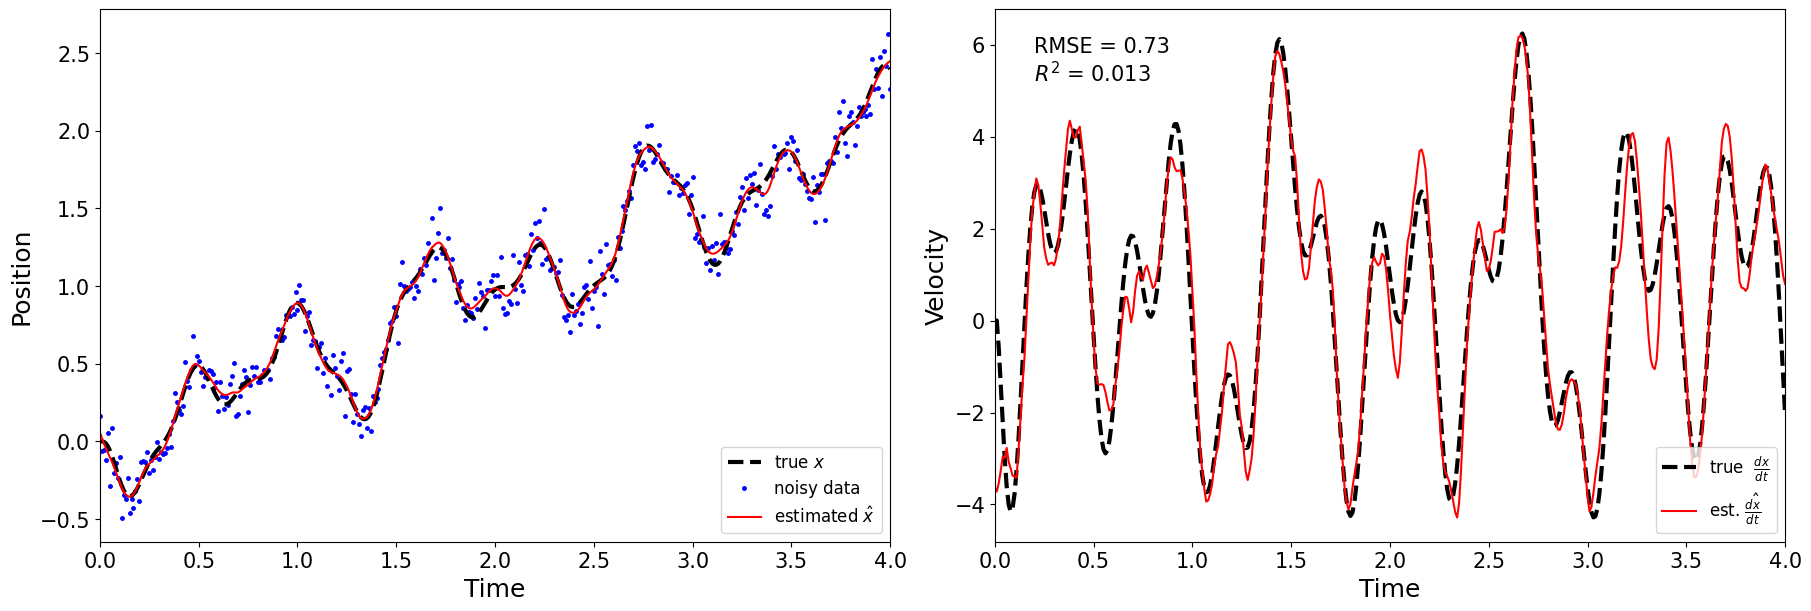

In [14]:
params, val = optimize(rtsdiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters:', params)
x_hat, dxdt_hat = rtsdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

params, val = optimize(rtsdiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters:', params, 'loss:', val)
x_hat, dxdt_hat = rtsdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

### Huber/$\ell_1$ Smoothing

The 5-dimensional hyperparameter space makes this one significantly slower to optimize.

Optimal parameters: {'log_q': np.float64(15.66315917968749), 'log_r': np.float64(5.772851562499987), 'proc_huberM': np.float64(2.3827636718749954), 'meas_huberM': np.float64(5.720068359374995), 'order': 3}
Optimal parameters: {'log_q': np.float64(9.249267578125), 'log_r': np.float64(2.1256103515624996), 'proc_huberM': np.float64(2.0359130859374996), 'meas_huberM': np.float64(5.869482421875), 'order': 2} cost: 0.10544070065732236


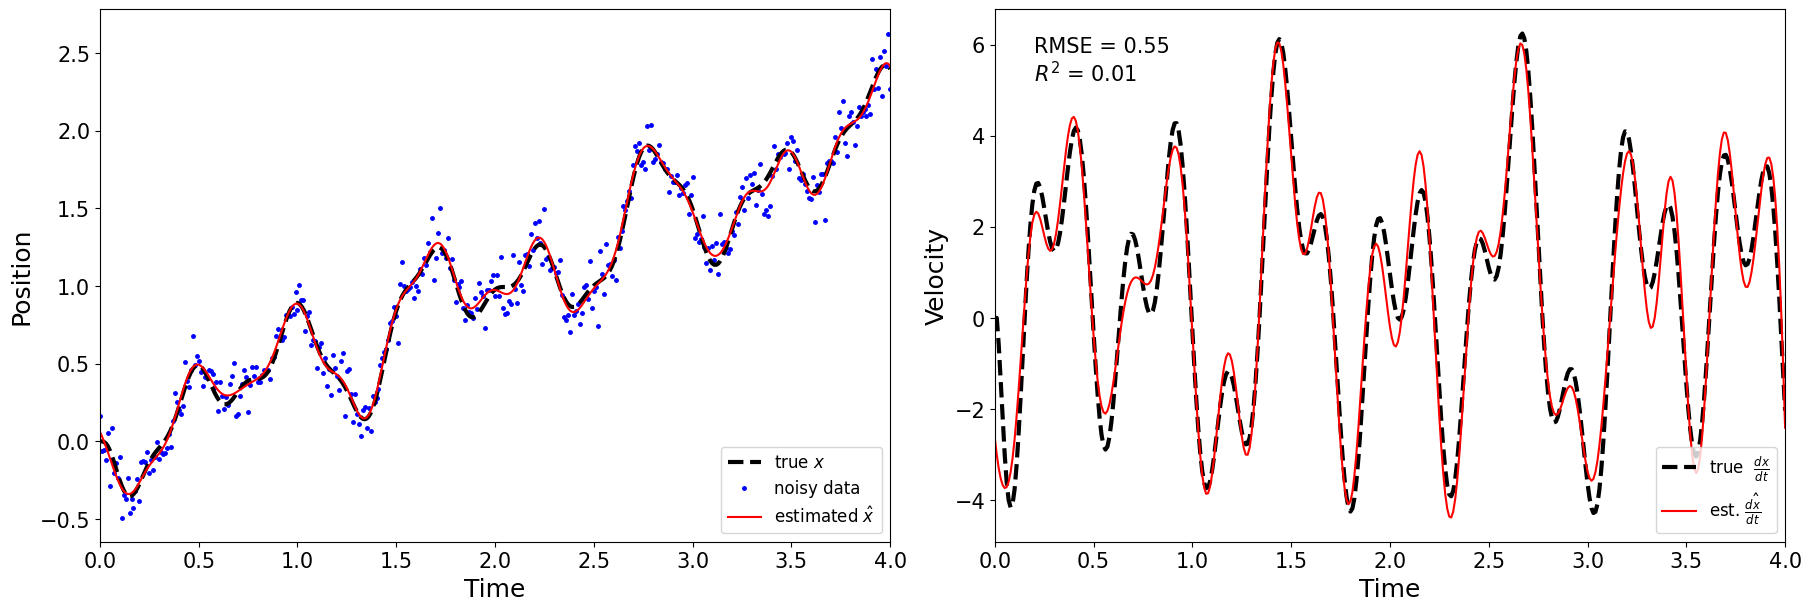

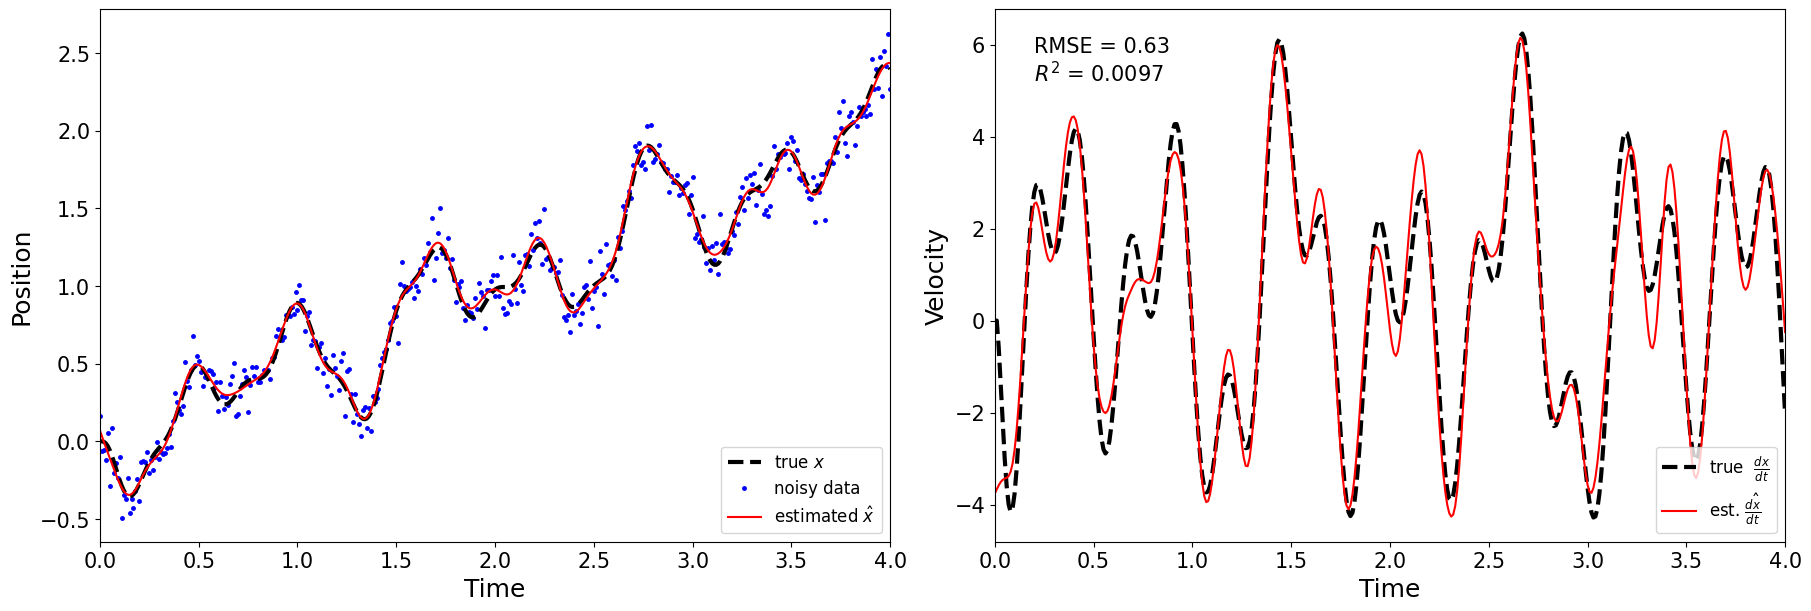

In [15]:
params, val = optimize(robustdiff, x, dt, dxdt_truth=dxdt_truth)
print('Optimal parameters:', params)
x_hat, dxdt_hat = robustdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

params, val = optimize(robustdiff, x, dt, tvgamma=tvgamma, search_space_updates={'order':{2,3}})
print('Optimal parameters:', params, 'cost:', val)
x_hat, dxdt_hat = robustdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

## 7. Linear Model: Sliding linear time invariant system fit

In [16]:
if 0: # this one is too slow and runtime error prone!
	params, val = optimize(lineardiff, x, dt, dxdt_truth=dxdt_truth)
	print('Optimal parameters:', params)
	x_hat, dxdt_hat = lineardiff(x, dt, **params)
	evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);

	params, val = optimize(lineardiff, x, dt, tvgamma=tvgamma)
	print('Optimal parameters:', params, 'cost:', val)
	x_hat, dxdt_hat = lineardiff(x, dt, **params)
	evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth);